In [1]:

# # Uncomment to widen notebook cells for PDf export
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Image Processing Lab 3
## Zhanwen (Phil) Chen

1.

This problem explores the changes in color that occur when the individual bands of a true-color image are transformed independently of each other.
Find a truecolor image that contains a wide range of colors. Use the gamma correction function you wrote for Lab Assignment 2 to increase and decrease the overall brightness of each band separately. Display the original image and the 6 altered versions. Describe the differences between the images. Here, I recommend that you cut the same small region out of the original and the 6 altered images so that you can display them all on the same page together. These need not be enlarged. See Figure 1.

In [2]:
import numpy as np

def get_lut_gamma(gamma):
    adjusted = np.power(np.arange(256)/255, 1.0/gamma) * 255
    return np.rint(adjusted).clip(0, 255).astype('uint8')

def gamma_adjust(image, gamma, which_band=-1):
    lut_gamma = get_lut_gamma(gamma)
    if which_band == -1:
        return lut_gamma[image]
    
    new_channel = lut_gamma[image[:, :, which_band]]
    if which_band == 0:
        return np.dstack([new_channel, image[:, :, 1], image[:, :, 2]])
    
    if which_band == 1:
        return np.dstack([image[:, :, 0], new_channel, image[:, :, 2]])
    
    if which_band == 2:
        return np.dstack([image[:, :, 0], image[:, :, 1], new_channel])

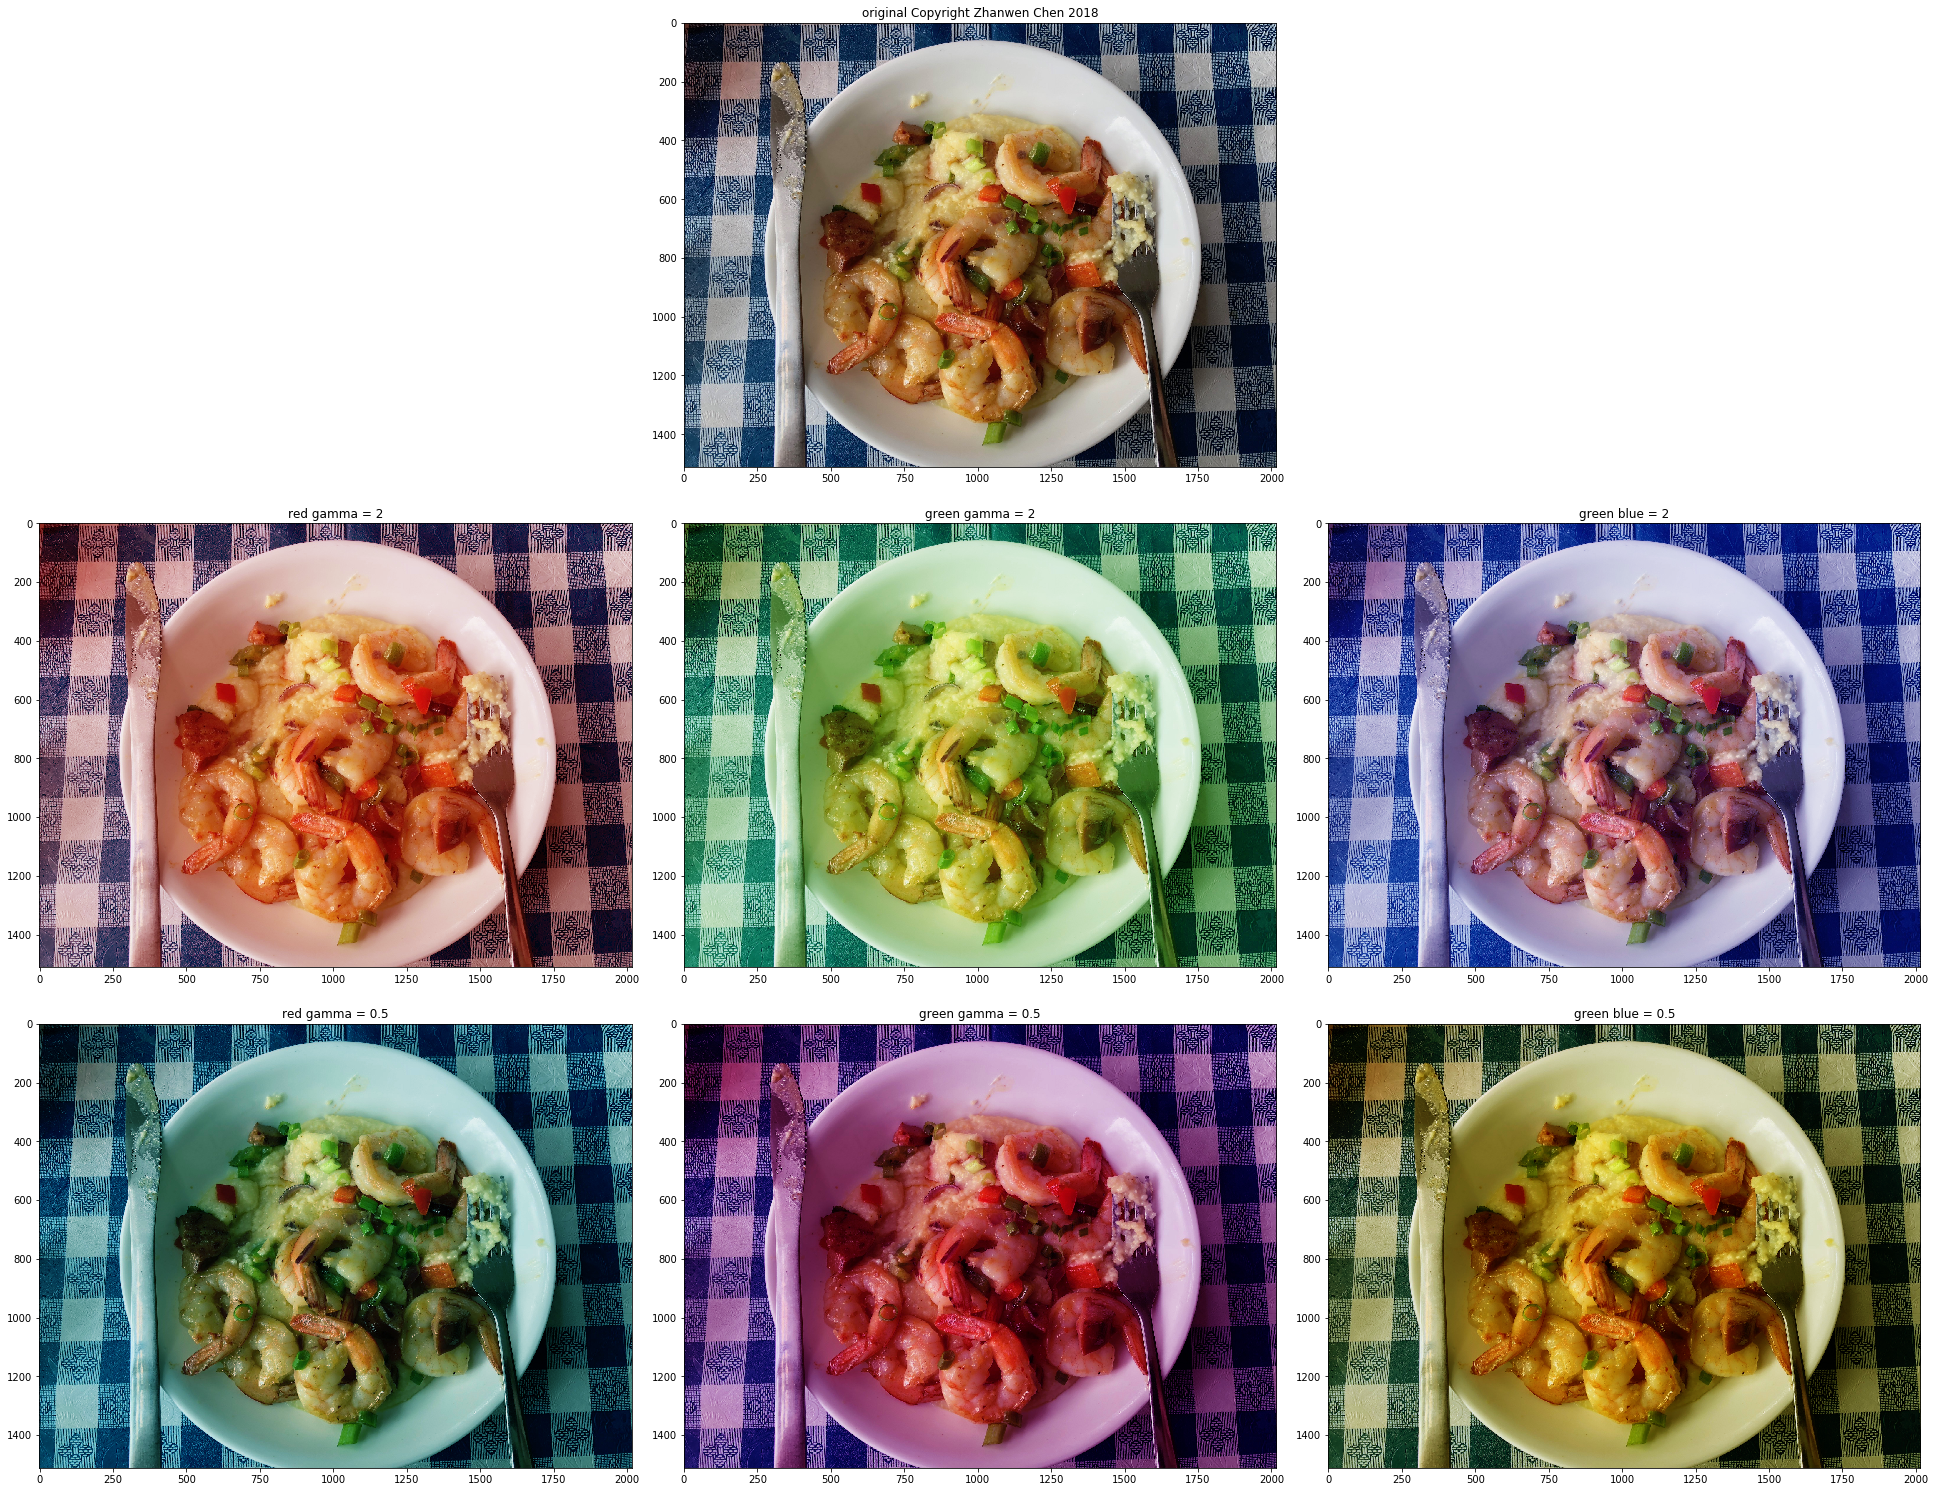

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

image_fname = 'nashville_jam_cafe.jpg'
image_original = plt.imread(image_fname)

image_gamma_red_2 = gamma_adjust(image_original, 2, which_band=0)
image_gamma_red_0_5 = gamma_adjust(image_original, 0.5, which_band=0)

image_gamma_green_2 = gamma_adjust(image_original, 2, which_band=1)
image_gamma_green_0_5 = gamma_adjust(image_original, 0.5, which_band=1)

image_gamma_blue_2 = gamma_adjust(image_original, 2, which_band=2)
image_gamma_blue_0_5 = gamma_adjust(image_original, 0.5, which_band=2)

fig, axes = plt.subplots(3, 3, figsize=(27, 21))
fig.delaxes(axes[0,0])
fig.delaxes(axes[0,2])

axes[0,1].imshow(image_original)
axes[0,1].set_title('original Copyright Zhanwen Chen 2018')

axes[1,0].imshow(image_gamma_red_2)
axes[1,0].set_title('red gamma = 2')
axes[2,0].imshow(image_gamma_red_0_5)
axes[2,0].set_title('red gamma = 0.5')

axes[1,1].imshow(image_gamma_green_2)
axes[1,1].set_title('green gamma = 2')
axes[2,1].imshow(image_gamma_green_0_5)
axes[2,1].set_title('green gamma = 0.5')

axes[1,2].imshow(image_gamma_blue_2)
axes[1,2].set_title('green blue = 2')
axes[2,2].imshow(image_gamma_blue_0_5)
axes[2,2].set_title('green blue = 0.5')

plt.tight_layout()
plt.show()

2.

Manipulation of HSV images.

&nbsp;

(a) Use the same image you used in problem 1. Convert the image to HSV using the RGBtoHSV function you wrote for Homework 3. Apply your gamma function to the V band, both to increase it and to decrease it. Reconstruct two new images using the altered V bands via your HSVtoRGB function. Include the results on the the same page of your report – either the full images or the same regions from both. Describe the results.

In [4]:
def rgb_to_hsv(image, in_degrees=False):
    # Edge Case 1: If image is in a list format, convert it to a numpy array.
    if isinstance(image, list):
        image = np.array(image)
        
    # Edge Case 2: If image is a pixel of shape (3,), promote it to (1, 1, 3)
    if image.ndim == 1:
        image = image[None, None, :]
        
    rgb_sum = np.sum(image, axis=-1, keepdims=True)
    
    # 1. Comute scalar value image, v
    scalar_value_image = rgb_sum/3.

    # 2. Compute vector value image V = [v v v]
    vector_value_image = np.tile(scalar_value_image, (1, 3))
#     print('2. vector_value_image.shape =', vector_value_image.shape)
#     print('2. vector_value_image =', vector_value_image)

    # 3. Computer vector saturation image, s = I - V
    vector_saturation_image = image - vector_value_image

    # 4. Compute scalar saturation image s = ||s||
    scalar_saturation_image = np.linalg.norm(vector_saturation_image, axis=-1, keepdims=True)

    # 5. Compute red axis vector image, X = [2v -v -v]
    red_axis_vector_image = np.dstack([2*scalar_value_image, -scalar_value_image, -scalar_value_image])

    # 6. Compute red axis scalar image, x = ||X||
    red_axis_scalar_image = np.linalg.norm(red_axis_vector_image, axis=-1, keepdims=True)

    # 7. Set s(s==0)=1 and x(x==0)=1
    scalar_saturation_image[scalar_saturation_image == 0] = 1
    red_axis_scalar_image[red_axis_scalar_image == 0] = 1

    # 8. Compute hue cosine image, c = (S*X) / (s*x)
    hue_cosine_image = np.sum(vector_saturation_image * red_axis_vector_image, axis=-1, keepdims=True) / (scalar_saturation_image * red_axis_scalar_image)

    # 9. Hard limit hue_cosine image
    hue_cosine_image = hue_cosine_image.clip(-1, 1)

    # 10. Compute the hue angle image
    hue_angle_image = np.arccos(hue_cosine_image)

    # 11. Create logical image, m = b > g
    logical_image = np.expand_dims(image[:, :, 1] < image[:, :, 2], -1)

    # 12. Adjust h = ~m*h + m * (2pi - h)
    hue_angle_image = ~logical_image * hue_angle_image + logical_image * (2 * np.pi - hue_angle_image)
    
    if in_degrees is True:
        hue_angle_image = np.degrees(hue_angle_image)

    # 13. Normalize the saturation s
    scalar_saturation_image = np.clip(scalar_saturation_image/208.2066, 0, 1)

    # 14. return (h, s, v)
    return np.dstack([hue_angle_image, scalar_saturation_image, np.rint(scalar_value_image).clip(0, 255)])
#     return np.dstack([hue_angle_image, scalar_saturation_image, scalar_value_image])

In [5]:
def hsv_to_rgb(image_hsv):
    # Edge Case 1: If image is in a list format, convert it to a numpy array.
    if isinstance(image_hsv, list):
        image = np.array(image_hsv)
        
    # Edge Case 2: If image is a pixel of shape (3,), promote it to (1, 1, 3)
    if image_hsv.ndim == 1:
        image_hsv = image_hsv[None, None, :]
        
    # 1. Reshape R×C images h, s, and v into RC×1 column vectors
    hue_angle_image = image_hsv[:, :, 0]
    scalar_saturation_image = image_hsv[:, :, 1]
    scalar_value_image = np.expand_dims(image_hsv[:, :, 2], axis=-1)
    
    # 2. Denormalize the saturation image, s = 208.2066⋅s
    scalar_saturation_image = np.multiply(208.2066, scalar_saturation_image)
#     print('2. after denormalize, scalar_saturation_image =', scalar_saturation_image)

    # 3. Compute the x-coordinate image, x = s⋅cos(h)
    x = np.expand_dims(scalar_saturation_image * np.cos(hue_angle_image), axis=-1)

    # 4. Compute the y-coordinate image, y = s⋅sin(h)
    y = np.expand_dims(scalar_saturation_image * np.sin(hue_angle_image), axis=-1)

    # 5. Construct the value vector image, V = [v v v]T
    vector_value_image = np.tile(scalar_value_image, (1, 3))
    
    # 6. Construct the 1st two columns of rotation matrix A 
    rotation_matrix = np.sqrt(6.) / 6. * np.array([[2., -1., -1.],
                                     [0, np.sqrt(3.), -np.sqrt(3.)]])
    
    # 7. Rotate the saturation image S = [s1 s2 s3]T = A[x y]T 
    vector_saturation_image = np.dot(np.dstack([x, y]), rotation_matrix)

    # 8. Add the result to V to recover I_RGB =S+V
    image_rgb = vector_saturation_image + vector_value_image

    # 9. Round IRGB, convert it to uint8, and reshape it to R×C×3
    I_rgb = np.rint(image_rgb).clip(0, 255).astype(np.uint8)
    
    return I_rgb


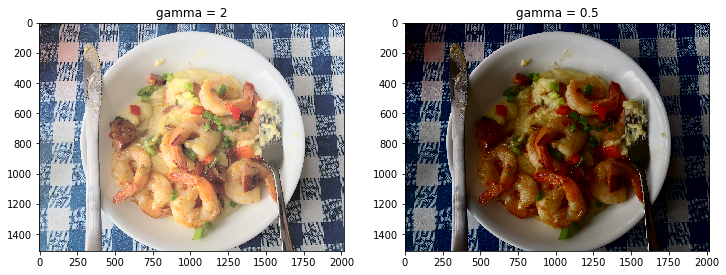

In [6]:
image_hsv = rgb_to_hsv(image_original)

image_hsv_gamma_2_v = gamma_adjust(image_hsv[:, :, 2].astype(np.uint8), 2, which_band=-1)
image_hsv_gamma_2 = np.dstack([image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv_gamma_2_v])

image_hsv_gamma_0_5_v = gamma_adjust(image_hsv[:, :, 2].astype(np.uint8), 0.5, which_band=-1)
image_hsv_gamma_0_5 = np.dstack([image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv_gamma_0_5_v])

image_hsv_gamma_2_rgb = hsv_to_rgb(image_hsv_gamma_2)
image_hsv_gamma_0_5_rgb = hsv_to_rgb(image_hsv_gamma_0_5)

fig, axes = plt.subplots(1, 2, figsize=(12, 12))

axes[0].imshow(image_hsv_gamma_2_rgb)
axes[0].set_title('gamma = 2')
axes[1].imshow(image_hsv_gamma_0_5_rgb)
axes[1].set_title('gamma = 0.5')

plt.show()

2.

(b) Linearly increase and linearly decrease the saturation. Reconstruct two new images using the altered S bands via your HSV-to-RGB function. Describe the results. Note that a linear increase may increase the value of the saturation of some pixels to > 1. You will need to clip the results at 1, prior to the conversion back to RGB. Include the results on the same page of your report – either the full images or the same regions from both. Describe the results.

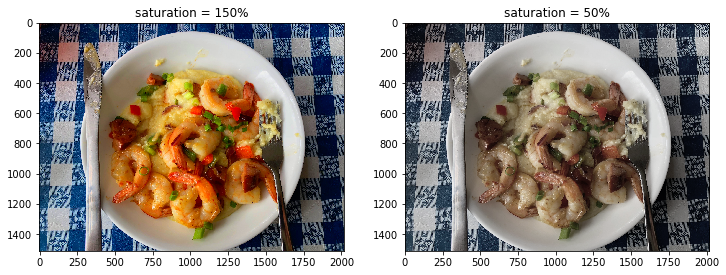

In [7]:
image_hsv_saturation_150_s = np.clip(image_hsv[:, :, 1] * 1.5, 0, 1)
image_hsv_saturation_150 = np.dstack([image_hsv[:, :, 0], image_hsv_saturation_150_s, image_hsv[:, :, 2]])

image_hsv_saturation_150_rgb = hsv_to_rgb(image_hsv_saturation_150)

image_hsv_saturation_50_s = np.clip(image_hsv[:, :, 1] * 0.5, 0, 1)
image_hsv_saturation_50 = np.dstack([image_hsv[:, :, 0], image_hsv_saturation_50_s, image_hsv[:, :, 2]])

image_hsv_saturation_50_rgb = hsv_to_rgb(image_hsv_saturation_50)

fig, axes = plt.subplots(1, 2, figsize=(12, 12))

axes[0].imshow(image_hsv_saturation_150_rgb)
axes[0].set_title('saturation = 150%')
axes[1].imshow(image_hsv_saturation_50_rgb)
axes[1].set_title('saturation = 50%')

plt.show()


2.

(c) Apply a constant circular shift to the H band to shift the colors in the green direction from hue = 0. Note that a circular shift of amount δ away from red toward green could cause the hues of some pixels to exceed 2π. These must be “wrapped around”. That is, if H(r,c) > 2π then replace H(r,c) with H(r,c)−2π. This can be done also with modulo 2π arithmetic.
Repeat the same experiment but shift the colors in the blue direction. Note that you must perform an analogous wrapping to deal with the pixels whose hues are shifted to below zero in value.
Reconstruct 2 new images using the altered H bands via your program HSVtoRGB. Include the results on the the same page of your report – either the full images or the same regions from both. Describe the results. How do these results differ from those of problem 1?

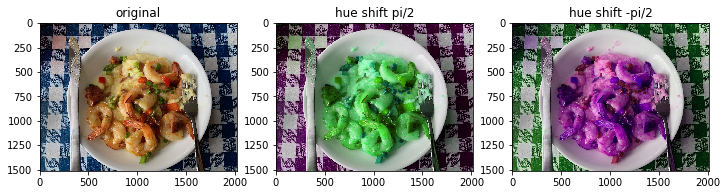

In [28]:
shifted_pi_2_h = original_h + np.pi/2
shifted_pi_2_and_modded_h = np.mod(shifted_pi_2_h, 2*np.pi)
shifted_pi_2_and_modded_rgb = hsv_to_rgb(np.dstack([shifted_pi_2_and_modded_h, image_hsv[:, :, 1], image_hsv[:, :, 2]]))

shifted_neg_pi_2_h = original_h - np.pi/2
shifted_neg_pi_2_and_modded_h = np.mod(shifted_neg_pi_2_h, 2*np.pi)
shifted_neg_pi_2_and_modded_rgb = hsv_to_rgb(np.dstack([shifted_neg_pi_2_and_modded_h, image_hsv[:, :, 1], image_hsv[:, :, 2]]))

fig, axes = plt.subplots(1, 3, figsize=(12, 12))

axes[0].imshow(original_h_rgb)
axes[0].set_title('original')

axes[1].imshow(shifted_pi_2_and_modded_rgb)
axes[1].set_title('hue shift pi/2')

axes[2].imshow(shifted_neg_pi_2_and_modded_rgb)
axes[2].set_title('hue shift -pi/2')

plt.show()


3.

Correction of an image with a hue shift. Download the image.

    PhotoDiskTestImageHueShifted.bmp

Download and read,

    PhotoDiskTestImageReadMe.pdf

from the lab assignment 3 folder on Brightspace. The readme file contains information about the image. The image has been hue shifted into an unnatural color spectrum. Convert the image into HSV and try to shift it back into the correct color range. There are reference colors in the matrix of squares in the second row of objects. The row of colors just above the grayscale blocks are blue, green, red, yellow, magenta, and cyan. Include your estimate of the color shift in degrees from the correctly colored image to the discolored one. E.g. d ∈ {−π, π} such that the hues in the discolored image were d+ the hues in the original image. Include the original, discolored image and the color

In [12]:
photo_disk = plt.imread('PhotoDiskTestImageHueShifted.bmp')
photo_disk_hsv = rgb_to_hsv(photo_disk)

AttributeError: 'str' object has no attribute 'ndim'